In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
project <- c("CESC", "UCS", "UCEC")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_list <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
dset_idx <- 3

In [4]:
text_size <- 8
# guide_size <- 4
guide_size <- 1
family <- "ArialMT"
dpi <- 320
ht <- 4
wd <- 5
pt_to_mm <- 5 / 14

In [5]:
matrisome_df <- rutils::load_matrisome_df(matrisome_list) %>%
    dplyr::select(gene_symbol, division, category) %>%
    dplyr::rename(geneID = gene_symbol)

counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/counts.tsv")) %>%
    dplyr::rename("geneID" = "Hugo_Symbol") %>%
    dplyr::select(-"Entrez_Gene_Id")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
i Use `spec()` for the full column specifications.




In [6]:
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
figo_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))
figo_list <- figo_umsmg_list %>%
    union(figo_nsmg_list)

In [7]:
length(demg_list)
length(figo_umsmg_list)
length(figo_nsmg_list)
length(figo_list)
length(intersect(figo_list, demg_list))

[1] 618

[1] 101

[1] 263

[1] 322

[1] 207

In [8]:
matrisome_category_levels <- c("Proteoglycans", "Collagens", "ECM-affiliated Proteins", "ECM Glycoproteins", "ECM Regulators", "Secreted Factors")
genes_in_dset <- counts_df$geneID
matrisome_mem_df <- matrisome_df %>%
    filter(geneID %in% genes_in_dset) %>%
    dplyr::mutate(
        de = geneID %in% demg_list,
        predictive = geneID %in% figo_list,
        both = de & predictive
    ) %>%
    dplyr::mutate(membership = case_when(
        de & !both ~ "DE only",
        predictive & !both ~ "Stage sig. only",
        both == TRUE ~ "Stage sig. & DE",
        !de & !predictive ~ "Neither"),
        category = factor(category, levels = matrisome_category_levels)
    ) %>%
    dplyr::mutate(membership = factor(membership, levels = c("Stage sig. only", "Stage sig. & DE", "DE only", "Neither")))

In [9]:
matrisome_bp_df <- matrisome_mem_df %>%
    group_by(category, membership) %>%
    summarize(cat_counts = n())

`summarise()` has grouped output by 'category'. You can override using the `.groups` argument.



In [10]:
head(matrisome_bp_df)

category,membership,cat_counts
<fct>,<fct>,<int>
Proteoglycans,Stage sig. only,5
Proteoglycans,Stage sig. & DE,2
Proteoglycans,DE only,22
Proteoglycans,Neither,6
Collagens,Stage sig. only,5
Collagens,Stage sig. & DE,10


In [11]:
sum(matrisome_bp_df$cat_counts)

[1] 1008

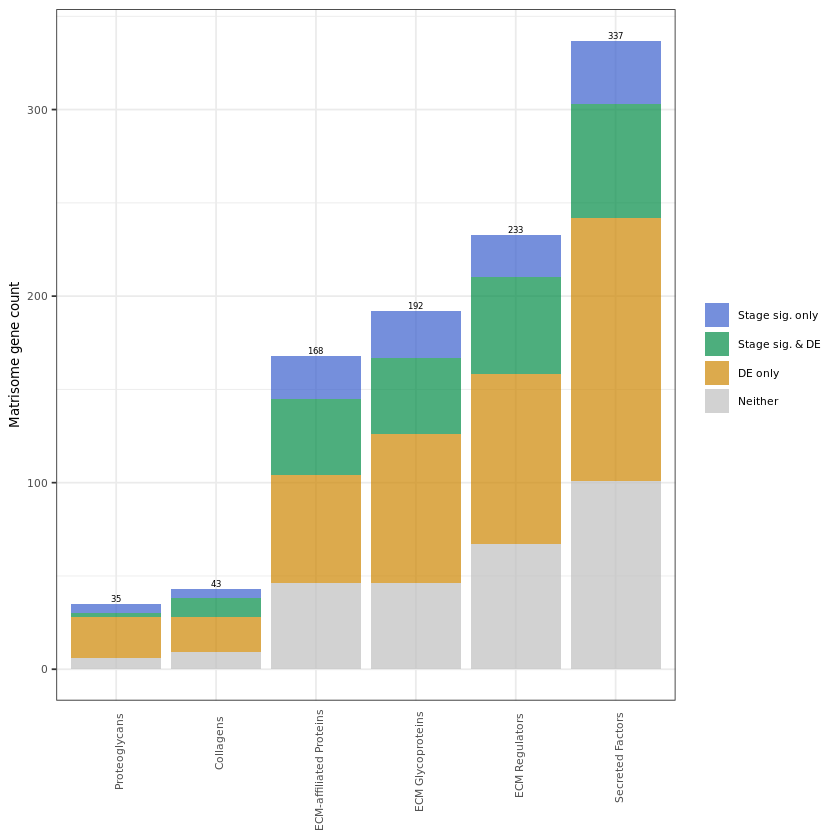

In [12]:
# sig_color_scale <- c("Not sig." = "gray30","FIGO sig. only" = "steelblue3", "FIGO sig. and DE" = "darkorchid4", "DE only" = "firebrick3")
sig_color_scale <- c("Neither" = "gray75","Stage sig. only" = "royalblue3", "Stage sig. & DE" = "springgreen4", "DE only" = "orange3")
ggplot(data = matrisome_bp_df, aes(x = category, y = cat_counts, fill = membership)) +
    geom_bar(stat = "identity", alpha = 0.7) +
#     geom_text(aes(label = cat_counts), position = position_stack(vjust = 0.5), color = "gray90", size = (text_size - 3) * pt_to_mm) +
    stat_summary(fun = sum, aes(label = ..y.., group = category), geom = "text", vjust = -0.25, size = (text_size - 3) * pt_to_mm) +
    scale_fill_manual(values = sig_color_scale, name = NULL) +
    guides(fill = guide_legend(override.aes = list(size = guide_size))) +
    theme_bw() +
    theme(
        text = element_text(size = text_size, family = family),
        axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
        axis.title.x = element_blank()
    ) +
    labs(y = "Matrisome gene count")

In [13]:
ggsave(paste0(dirs$figures_dir, "/deg/", unified_dsets[dset_idx], "_figo_sig_demg_stacked_bp.png"), last_plot(), height = ht, width = wd, dpi = dpi)

In [14]:
category_bplot <- last_plot()

In [15]:
assign(paste0(project[dset_idx], "_mat_sig_bplot"), category_bplot)
save(
    list = c(paste0(project[dset_idx], "_mat_sig_bplot")),
    file = paste0(dirs$figures_dir, "/saved_obj/", unified_dsets[dset_idx], "_mat_sig_bplots.RData")
)